In [ ]:
# ! pip install ultralytics roboflow opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from collections import Counter
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import  img_to_array
import Augmentor

In [24]:
CLASS_NAME = ['0', 'car', 'helmet', 'license plate', 'motorcycle', 
                'no helmet', 'no seat belt', 'person', 'seatbelt']
PATH = "Seatbelt Helmet Detection.v6i.yolov8"

DATASET_PATH = {
        "train": f"{PATH}/train",
        "val": f"{PATH}/valid",
        "test": f"{PATH}/test"
    }

In [25]:
#Fonction personnel pour afficher les images avec ces plot
def plot_image(name, path):
    #Labeling view
    label_path = path+"/labels/"
    image_path = path+"/images/"

    # Lire le fichier de label
    with open(label_path+name+".txt", 'r') as label_file:
        labels = label_file.readlines()

    image = cv2.imread(image_path+name+".jpg")
    image = np.asarray(image)

    # Récupérer les dimensions de l'image
    h, w, _ = image.shape

    # Parcourir les labels et dessiner les bounding boxes
    for line in labels:
        values = line.strip().split()
        
        class_id = int(values[0])  # ID de la classe
        x_center, y_center, box_width, box_height = map(float, values[1:])

        # Convertir YOLO format (x_center, y_center, width, height) en pixels
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        class_name = CLASS_NAME[class_id]

        # Dessiner le rectangle sur l'image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vert
        cv2.putText(image, f"Class {class_name}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off') 
    plt.show()

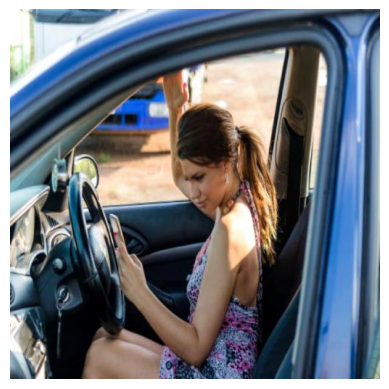

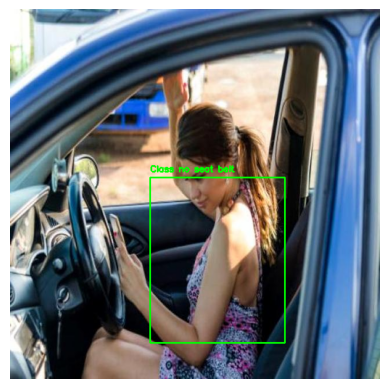

In [26]:
image = cv2.imread(f"{PATH}/train/images/-515_jpg.rf.38c81f5d9ba118cc468cfdf1051036a4.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Désactive les axes
plt.show()

plot_image(name="-515_jpg.rf.38c81f5d9ba118cc468cfdf1051036a4", path=f"{PATH}/train")

Etudions la distribution

In [27]:
def get_distribution(class_names =CLASS_NAME,annotation_paths = DATASET_PATH):
    # Stockage des occurrences de chaque classe
    class_counts = {subset: Counter() for subset in annotation_paths}

    # Lire les annotations et compter les classes
    for subset, path in annotation_paths.items():
        label_path = path+"/labels"
        for file in glob.glob(os.path.join(label_path, "*.txt")):
            try :
                with open(file, "r") as f:
                    for line in f:
                        class_id = int(line.split()[0])  # Première valeur de la ligne = classe
                        #print(class_id)
                        class_counts[subset][class_id] += 1
            except Exception as e:
                print(f"Erreur lors de la lecture de '{file}' : {e}")
            

    # Affichage des distributions
    for subset, counts in class_counts.items():
        labels = [class_names[i] for i in counts.keys()]
        values = [counts[i] for i in counts.keys()]

        print(labels)
        print(values)
        
        plt.figure(figsize=(10, 5))
        plt.bar(labels, values, color="skyblue")
        plt.xlabel("Classes")
        plt.ylabel("Nombre d'instances")
        plt.title(f"Distribution des classes dans {subset}")
        plt.xticks(rotation=45)
        plt.show()

In [28]:
def get_image(class_target, class_names=CLASS_NAME, dataset_paths = DATASET_PATH):
    class_id_motorcycle = class_names.index(class_target)

    images = {}

    # Parcourir les fichiers d'annotation pour récupérer les images correspondantes
    for subset, base_path in dataset_paths.items():
        
        labels_path = os.path.join(base_path, "labels")
        images_path = os.path.join(base_path, "images")  


        for txt_file in glob.glob(os.path.join(labels_path, "*.txt")):
            #print(txt_file)
            try:
                with open(txt_file, "r") as f:
                    for line in f:
                        class_id = int(line.split()[0])  # Extraire l'ID de classe
                        if class_id == class_id_motorcycle:
                            # Trouver l'image correspondante
                            image_file = os.path.basename(txt_file).replace(".txt", ".jpg")
                            image_path = os.path.join(images_path, image_file)
                            if os.path.exists(image_path):
                                image = cv2.imread(image_path)
                                images[txt_file]=image
            except Exception as e:
                print(f"Erreur lors de la lecture de '{txt_file}' : {e}")
    return images

#"val": f"{PATH}/valid",
#"test": f"{PATH}/test"

Technique de data augmentation

- Transformation Géométrique
- Modifications des Couleurs
- Ajout de Bruit
- Transformation de l'Intensité
- Modification des Pixel Values
- Technique de Patchwork 
- Augmentation par Transformation de Couleurs


In [30]:
def generate_data(images, output_path="augmented_images", multiplicator=1):
    final_path = []

    # Création des différents générateurs d'augmentation
    datagens = [
        ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ),
        ImageDataGenerator(rotation_range=40,),
        ImageDataGenerator(width_shift_range=0.2,),
        ImageDataGenerator(height_shift_range=0.2,),
        ImageDataGenerator(zoom_range=0.2,),
        ImageDataGenerator(horizontal_flip=True),
        ImageDataGenerator(vertical_flip=True),
        ImageDataGenerator(brightness_range=[0.5, 1.5])
    ]
    
    if multiplicator > len(datagens):
        raise Exception(f"Le multiplicateur est plus grand que le nombre d'éléments dans datagens {len(datagens)}.")

    # Créer les répertoires nécessaires s'ils n'existent pas
    os.makedirs(output_path, exist_ok=True)
    images_path = os.path.join(output_path, "images")
    labels_path = os.path.join(output_path, "labels")
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)

    # Augmentation des images en fonction du multiplicateur
    for i in range(multiplicator):
        #print(f"Traitement du multiplicateur {i+1} / {multiplicator}")
        datagen = datagens[i]

        for label_file, image in images.items():
            try:
                # Lire le contenu du fichier d'étiquettes
                with open(label_file, 'r') as source_file:
                    content = source_file.read()

                # Convertir l'image en tableau numpy et la préparer pour l'augmentation
                x = img_to_array(image)
                x = x.reshape((1,) + x.shape)

                # Noter les fichiers existants avant la génération
                before_files = set(os.listdir(images_path))

                # Générer l'image augmentée
                for _ in datagen.flow(x, 
                                      batch_size=1, 
                                      save_to_dir=images_path,
                                      save_prefix='aug',
                                      save_format='jpg'):
                    # Identifier les nouveaux fichiers après la génération
                    after_files = set(os.listdir(images_path))
                    new_files = after_files - before_files

                    if new_files:
                        new_file = new_files.pop()  # Assigner le nouveau fichier
                        #print(f"Image générée : {new_file}")

                        # Créer le fichier d'étiquettes correspondant
                        label_name = os.path.splitext(new_file)[0] + '.txt'
                        label_path = os.path.join(labels_path, label_name)

                        # Sauvegarder le contenu des étiquettes
                        with open(label_path, 'w') as target_file:
                            target_file.write(content)
                        #print(f"Fichier d'étiquettes créé : {label_name}")

                        # Ajouter le chemin du fichier d'étiquette généré à final_path
                        final_path.append(label_name)
                    break  # Quitter la boucle après la génération d'une image

            except Exception as e:
                print(f"Erreur lors du traitement de '{label_file}': {e}")
                continue
    return final_path


In [31]:

def generate_data_2(num_generate=1, input_path=f"{PATH}/train",output_path="augmented_images"):
    
    # Définition des chemins avec os.path.join pour une meilleure portabilité
    output_image_path = os.path.join(output_path, "images")
    output_label_path = os.path.join(output_path, "labels")
    input_image_path = os.path.join(input_path, "images")
    input_label_path = os.path.join(input_path, "labels")

    # Vérification de l'existence des dossiers d'entrée
    if not os.path.exists(input_image_path):
        raise ValueError(f"Le dossier d'images d'entrée n'existe pas: {input_image_path}")
    if not os.path.exists(input_label_path):
        raise ValueError(f"Le dossier d'étiquettes d'entrée n'existe pas: {input_label_path}")

    # Création des dossiers de sortie
    os.makedirs(output_path, exist_ok=True)
    os.makedirs(output_image_path, exist_ok=True)
    os.makedirs(output_label_path, exist_ok=True)

    # Enregistrer l'état initial des fichiers
    before_files = set(os.listdir(output_image_path))

    # Configuration du pipeline Augmentor
    p = Augmentor.Pipeline(input_image_path)
    p.output_directory = output_image_path  # Définir explicitement le dossier de sortie

    # Définir les transformations
    p.flip_left_right(0.5)
    p.black_and_white(0.1)
    p.rotate(0.3, 10, 10)
    p.skew(0.4, 0.5)
    p.zoom(probability=0.2, min_factor=1.1, max_factor=1.5)

    def on_image_generated(pipeline, image, filename):
        print(f"Image générée : {filename}")
        # Ici, vous pourriez ajouter le code pour copier/modifier 
        # le fichier d'étiquettes correspondant

    p.generator.add_image_generated_callback(on_image_generated)

    # Générer les images
    p.sample(num_generate)

    # Récupérer les nouveaux fichiers générés
    after_files = set(os.listdir(output_image_path))
    new_files = after_files - before_files
    
    return list(new_files)

In [32]:
def empty_directory(directory):
    # Vérifier si le dossier existe
    if os.path.exists(directory):
        # Lister tous les fichiers et sous-dossiers
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            
            # Vérifier si c'est un fichier ou un dossier
            if os.path.isfile(file_path):
                os.remove(file_path)  # Supprimer le fichier
                #print(f"Fichier supprimé : {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Supprimer le sous-dossier et son contenu
                #print(f"Dossier supprimé : {file_path}")
        print(f"Le dossier {directory} Vidé.")
    else:
        print(f"Le dossier {directory} n'existe pas.")
    


def copy_files(src_dir, dest_dir, drop=False):
    # Créer le répertoire de destination s'il n'existe pas
    os.makedirs(dest_dir, exist_ok=True)
    
    # Lister tous les fichiers dans le répertoire source
    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        
        # Vérifier si c'est un fichier (et pas un répertoire)
        if os.path.isfile(src_file):
            dest_file = os.path.join(dest_dir, filename)
            shutil.copy2(src_file, dest_file)  # Copier le fichier avec les métadonnées
            print(f"Fichier copié : {filename}")
        else:
            print(f"Ce n'est pas un fichier : {filename}")
    if(drop):
        empty_directory(src_dir)

Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt'
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt'
Erreur lors de l

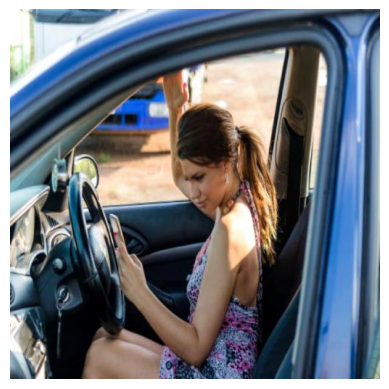

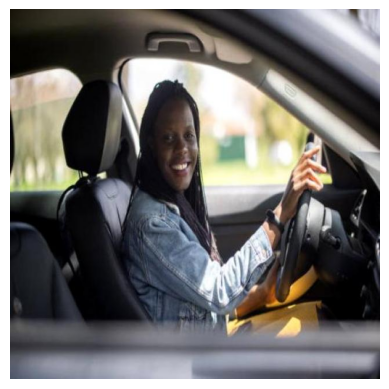

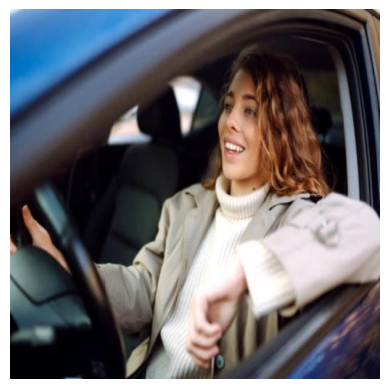

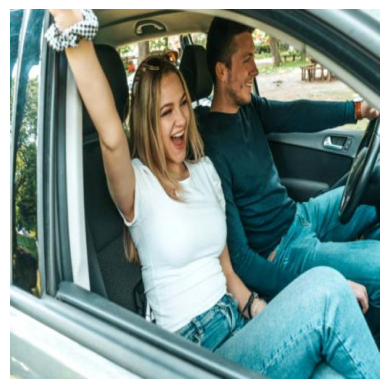

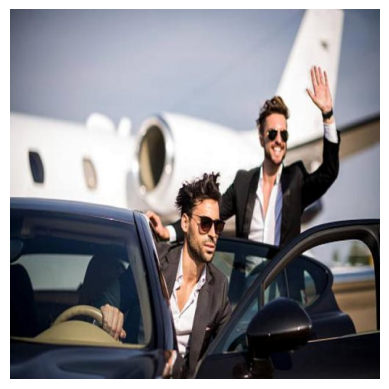

In [33]:
images = get_image(class_target="no seat belt", dataset_paths={"train": f"{PATH}/train"})

i = 0
for image in images.values():
    if i==5:
        break
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off') 
    plt.show()
    i+=1


In [34]:
empty_directory("augmented_images/labels")
empty_directory("augmented_images/images")

Le dossier augmented_images/labels Vidé.
Le dossier augmented_images/images Vidé.


Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt'
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt'
Erreur lors de l

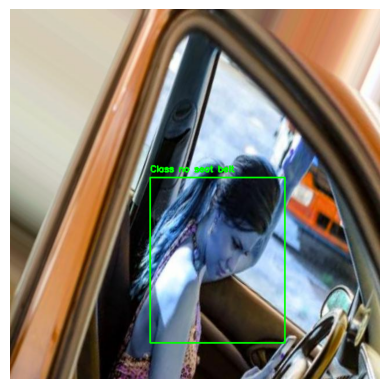

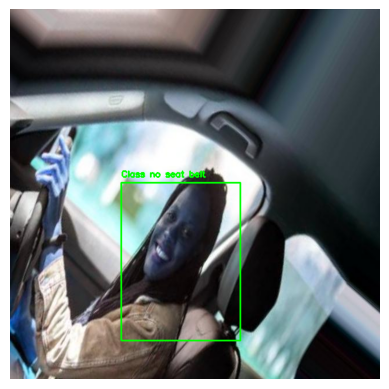

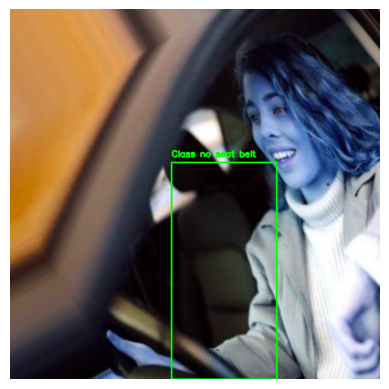

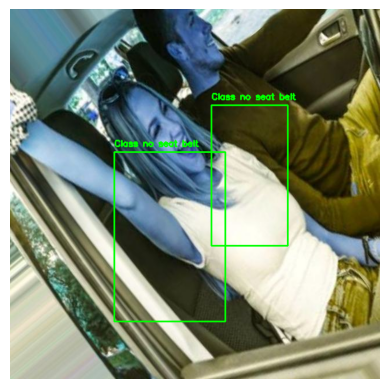

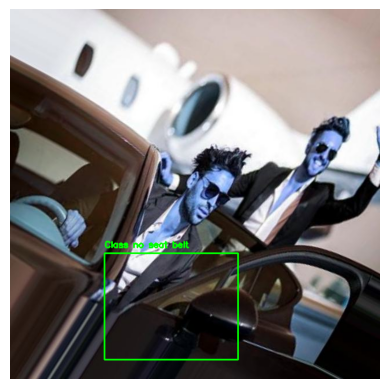

Le dossier augmented_images/labels Vidé.
Le dossier augmented_images/images Vidé.


In [35]:
i=0
images = get_image(class_target="no seat belt", dataset_paths={"train": f"{PATH}/train"})

for label_name in generate_data(images=images,multiplicator=1):
    if(i==5):
        break
    plot_image(name=label_name.replace(".txt",""), path="augmented_images")
    i+=1
#copy_files(src_dir="augmented_images/images",dest_dir=f"{PATH}/train/images",drop=True)
#copy_files(src_dir="augmented_images/labels",dest_dir=f"{PATH}/train/labels",drop=True)
empty_directory("augmented_images/labels")
empty_directory("augmented_images/images")

In [36]:
#['no seat belt', 'helmet', 'seatbelt', 'car', 'license plate', 'person', 'motorcycle', 'no helmet', '0']~
# [121, 88, 435, 65, 67, 92, 38, 32, 1]
empty_directory("augmented_images/labels")
empty_directory("augmented_images/images")


multiplicator_class = {
    'no seat belt': 2, 
    'helmet': 5, 
    'car': 7,  
    'license plate': 5, 
    'person': 5,
    'motorcycle': 8,  
    'no helmet': 8,  
    '0': 8, 
}

affiche_result = {}

for class_name,multiplicator in multiplicator_class.items():
    images = get_image(class_target=class_name, dataset_paths={"train":f"{PATH}/train"})
    label_names = generate_data(images, multiplicator=multiplicator)
    affiche_result[class_name]=len(label_names)


affiche_result

Le dossier augmented_images/labels Vidé.
Le dossier augmented_images/images Vidé.
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt'
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daught

{'no seat belt': 191,
 'helmet': 380,
 'car': 407,
 'license plate': 297,
 'person': 365,
 'motorcycle': 247,
 'no helmet': 184,
 '0': 7}

Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt'
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt'
Erreur lors de la 

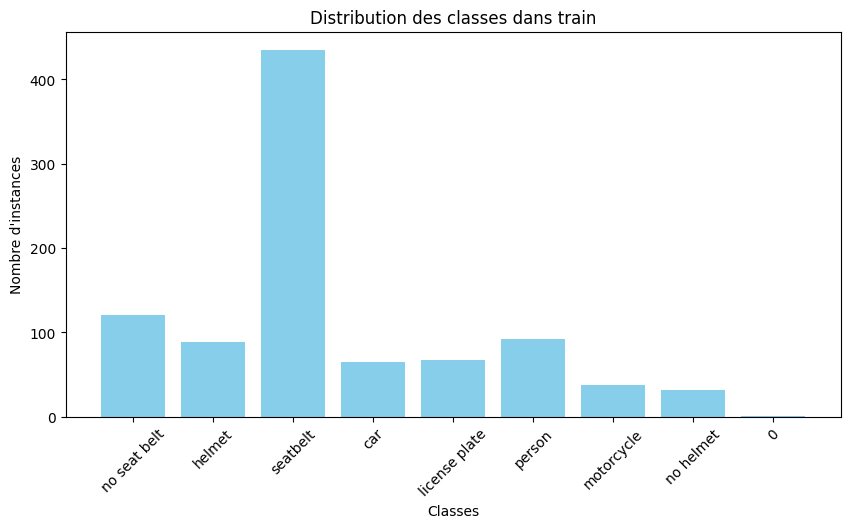

['no seat belt', 'helmet', 'car', 'license plate', 'person', 'seatbelt', 'motorcycle', 'no helmet', '0']
[31, 98, 23, 20, 21, 73, 6, 5, 1]


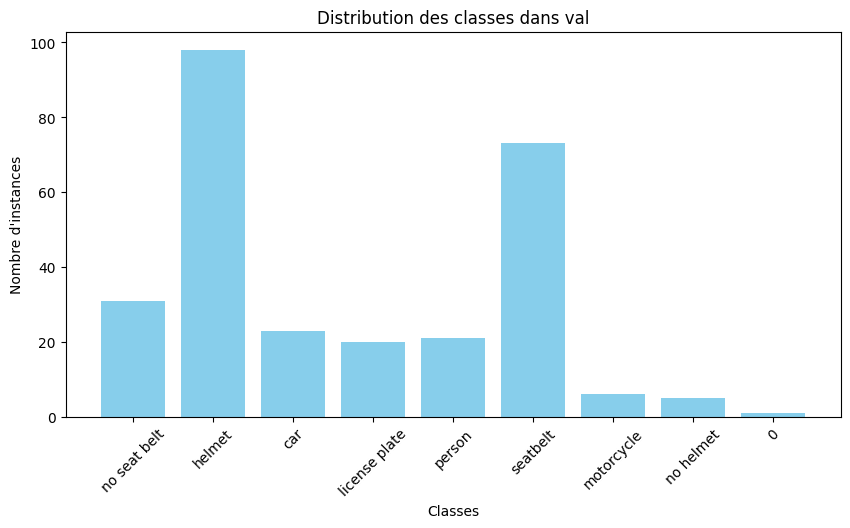

['car', 'license plate', 'no seat belt', 'person', 'motorcycle', 'helmet', 'no helmet', 'seatbelt']
[10, 14, 20, 14, 7, 7, 2, 51]


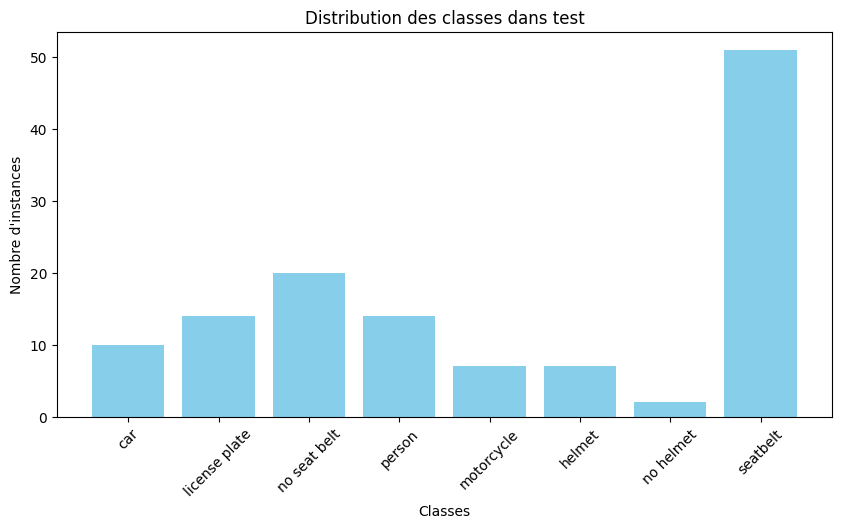

In [37]:
get_distribution()

ici toutes les classes sont à peu prés 4 à 6 fois inférieur à la classe sealbelt

In [ ]:
#['no seat belt', 'helmet', 'seatbelt', 'car', 'license plate', 'person', 'motorcycle', 'no helmet', '0']~
# [121, 88, 435, 65, 67, 92, 38, 32, 1]
multiplicator_class = {
    'no seat belt': 2, 
    'helmet': 5, 
    'car': 7,  
    'license plate': 5, 
    'person': 5,
    'motorcycle': 8,  
    'no helmet': 8,  
    '0': 8, 
}

for class_name,multiplicator in multiplicator_class.items():
    images = get_image(class_target=class_name, dataset_paths={"train":f"{PATH}/train"})
    label_names = generate_data(images, multiplicator=multiplicator)


copy_files(src_dir="augmented_images/images",dest_dir=f"{PATH}/train/images", drop=True)
copy_files(src_dir="augmented_images/labels",dest_dir=f"{PATH}/train/labels",drop=True)


Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt'
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train\labels\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train\\labels\\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt'
Erreur lors de l

Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\\shot-smiling-businessman-showing-something-his-laptop-to-business-partner-taxi-conversation-two-people-driving-car-107603001_webp.rf.0dfe949224079297d6fe2cf92ab993bb.txt'
Erreur lors de la lecture de 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt' : [Errno 2] No such file or directory: 'Seatbelt Helmet Detection.v6i.yolov8/train/labels\\stock-photo-black-woman-smiling-and-wearing-seat-belt-while-sitting-with-her-daughter-in-car-2025706988_jpg.rf.99cbabd1bf87248f578c168e72f5609e.txt'
Erreur lors de la 

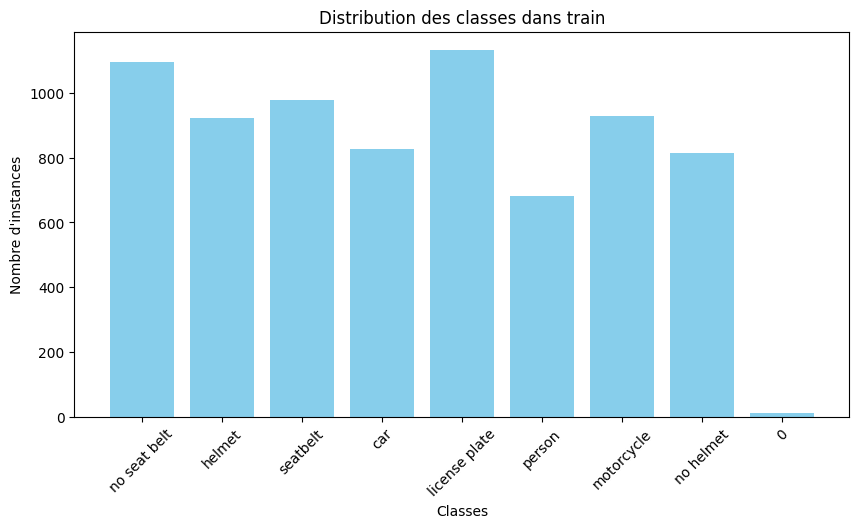

['no seat belt', 'helmet', 'car', 'license plate', 'person', 'seatbelt', 'motorcycle', 'no helmet', '0']
[31, 98, 23, 20, 21, 73, 6, 5, 1]


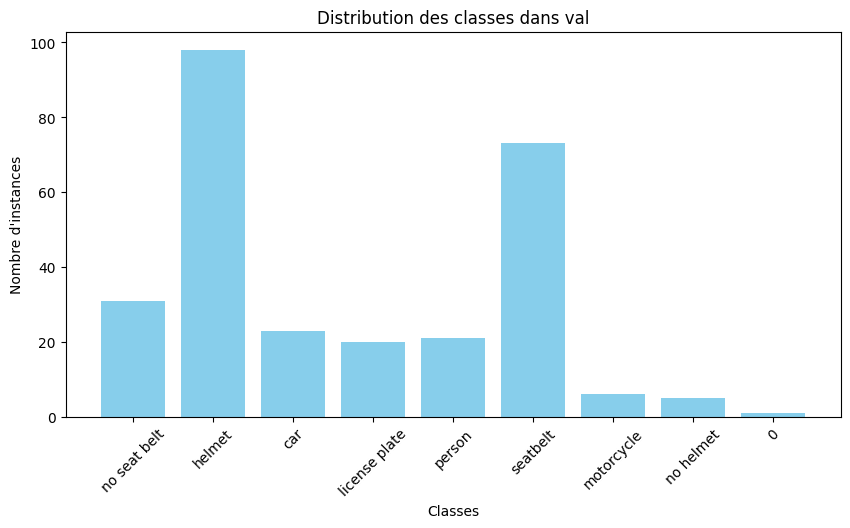

['car', 'license plate', 'no seat belt', 'person', 'motorcycle', 'helmet', 'no helmet', 'seatbelt']
[10, 14, 20, 14, 7, 7, 2, 51]


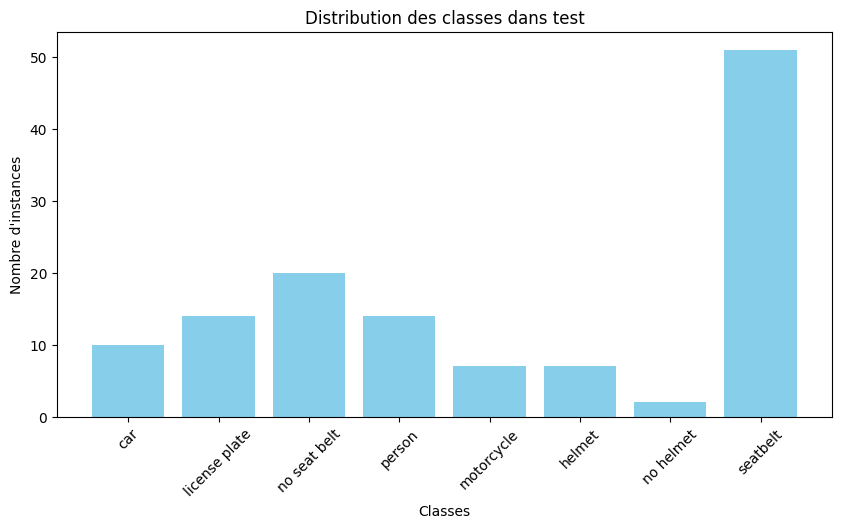

In [ ]:
get_distribution()

- 'no seat belt' => 1097,
- 'helmet'=>923, 
- 'seatbelt'=>977, 
- 'car'=>827, 
- 'license plate'=>1133, 
- 'person'=>682, 
- 'motorcycle'=>930, 
- 'no helmet'=>815, 
- '0'=>11
# 

- On se rend compte que le datset d'entrainement est plus ou moins équilibré
- On pourrais supprimer chercher à supprimer la classe 0